<a href="https://colab.research.google.com/github/LeticiaVieirg/Unet/blob/main/crack_thermal_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Importação das bibliotecas

In [38]:
import cv2
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization, Activation, Add, Input, AveragePooling2D
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import os, sys
from scipy import ndimage
import cv2
import matplotlib.pyplot as plt
import itertools
import scipy.stats
import tensorflow as tf
from keras import applications, optimizers, Input
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.multiclass import unique_labels


2. Acesso ao Google Colab para os arquivos


In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
folder='/content/drive/MyDrive/dataset/dataset'

3. ESTRUTURANDO O DATASET

In [28]:
image_width = 48
image_height = 48
channels = 3

train_files = []
i=0
for classes in ['Positive', 'Negative']:
    print(os.path.join(folder, classes))
    onlyfiles = [f for f in os.listdir(os.path.join(folder, classes)) if os.path.isfile(os.path.join(folder, classes, f ))]
    for _file in onlyfiles:
        train_files.append(_file)

dataset = np.ndarray(shape=(len(train_files), image_height, image_width, channels),
                     dtype=np.float32)
y_dataset = []

/content/drive/MyDrive/dataset/dataset/Positive
/content/drive/MyDrive/dataset/dataset/Negative


In [29]:
i = 0
for classes in ['Positive', 'Negative']:
    onlyfiles = [f for f in os.listdir(os.path.join(folder, classes)) if os.path.isfile(os.path.join(folder, classes, f))]
    for _file in onlyfiles:
        img_path = os.path.join(folder, classes, _file)
        img = load_img(img_path, target_size=(image_height, image_width))
        x = img_to_array(img)
        dataset[i] = x
        mapping = {'Positivez': 0 , 'Negative' : 1}
        y_dataset.append(mapping[classes])
        i += 1
        if i == 30000:
            print("%d images to array" % i)
            break

print("All images to array!")

All images to array!


5. NORMALIZAÇÃO DOS DADOS

In [30]:
#Normalização
dataset = dataset.astype('float32')
dataset /= 255

In [46]:
classes = ['Positive', 'Negative']

# Dicionário para armazenar o índice da primeira imagem de cada classe
first_image_index = {}

# Encontra o índice da primeira imagem de cada classe
for i, label in enumerate(y_dataset):
    if label not in first_image_index:
        first_image_index[label] = i

# Configura a grade para exibir as imagens
num_classes = len(set(y_dataset))
num_images_per_class = 1
num_cols = num_classes
num_rows = num_images_per_class

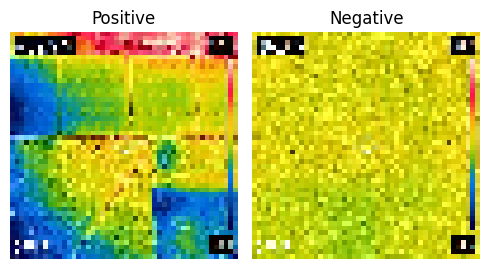

In [32]:
# Cria uma figura com uma grade de subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5, 5))

# Loop através de cada classe
for i in range(num_classes):
    # Obtém o índice da primeira imagem da classe
    idx = first_image_index[i]

    # Obtém a imagem e converte para RGB
    pixels = dataset[idx]

    # Exibe a imagem no subplot correspondente
    axes[i].imshow(pixels, cmap='Spectral')
    axes[i].axis('off')

    # Adiciona um título para o subplot com o rótulo
    axes[i].set_title(f'{classes[i]}')

# Exibe a figura
plt.tight_layout()
plt.show()

5. Normalizando o dataset

In [47]:

# categorical values
n_classes = len(set(y_dataset))
print(n_classes)

y_dataset_ = to_categorical(y_dataset, n_classes)

2


In [48]:
# Trim dataset to match the size of y_dataset_
dataset_trimmed = dataset[:len(y_dataset_)]

# Now both dataset_trimmed and y_dataset_ have the same size
# You can then proceed with splitting or any other operations

# Splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(dataset_trimmed, y_dataset_, test_size=0.2)

print("Train set size: {0}, Test set size: {1}".format(len(X_train), len(X_test)))

Train set size: 130, Test set size: 33


In [50]:
from sklearn.utils import resample

# Criar listas vazias para armazenar as amostras balanceadas
balanced_X_train = []
balanced_y_train = []

# Determinar o número de amostras na classe majoritária
majority_samples = 7000

# Iterar sobre cada classe
for class_label in np.unique(y_train.argmax(axis=1)):
    # Filtrar amostras pertencentes a essa classe
    X_class = X_train[y_train.argmax(axis=1) == class_label]
    y_class = y_train[y_train.argmax(axis=1) == class_label]

    # Calcular o número de amostras na classe menos representada
    minority_samples = len(X_class)

    # Balancear as amostras aumentando a classe menos representada
    balanced_X_class, balanced_y_class = resample(X_class, y_class,
                                                  replace=True,
                                                  n_samples=majority_samples,
                                                  random_state=42)

    # Adicionar amostras balanceadas à lista
    balanced_X_train.extend(balanced_X_class)
    balanced_y_train.extend(balanced_y_class)

# Converter listas em arrays numpy
balanced_X_train = np.array(balanced_X_train)
balanced_y_train = np.array(balanced_y_train)

# Embaralhar amostras
shuffled_indices = np.arange(len(balanced_X_train))
np.random.shuffle(shuffled_indices)
balanced_X_train = balanced_X_train[shuffled_indices]
balanced_y_train = balanced_y_train[shuffled_indices]

# Verificar o tamanho dos conjuntos de dados balanceados
print("Tamanho do conjunto de treinamento balanceado:", len(balanced_X_train))
print("Tamanho do conjunto de teste:", len(X_test))

for class_label in np.unique(balanced_y_train.argmax(axis=1)):
    count = np.sum(balanced_y_train.argmax(axis=1) == class_label)
    print(f"Classe {class_label}: {count} amostras")

Tamanho do conjunto de treinamento balanceado: 4
Tamanho do conjunto de teste: 33
Classe 0: 4 amostras


In [10]:
def split_data(
        train_df,
        test_df,
        image_width=227,
        image_height=227,
        image_channels=255.0,
        classes_names=["Positive", "Negative"],
        class_mode="binary",
        validation_split=0.2,
        preprocess_input=None,
):
    """
    Divide o dataset em treino, validação e teste

    Args:
        train_df (pd.DataFrame): dataframe com os dados das imagens de treino
        test_df (pd.DataFrame): dataframe com os dados das imagens de teste
        image_width (int): largura da imagem
        image_height (int): altura da imagem
        image_channels (int): número de canais da imagem
        classes_names (list): lista com os nomes das classes
        class_mode (str): modo de classificação, binário ou categórico
        validation_split (float): proporção de imagens para validação
        preprocess_input (None | list): preprocessa um tensor ou um array Numpy que codifica um lote de imagens

    Returns:
        train_data (pd.DataFrame): dataframe com os dados das imagens de treino
        valid_data (pd.DataFrame): dataframe com os dados das imagens de validação
        test_data (pd.DataFrame): dataframe com os dados das imagens de teste
    """

    image_size = (image_width, image_height)

    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1.0 / image_channels,
        validation_split=validation_split,
        preprocessing_function=preprocess_input,
    )

        #surface_crack_detection\utils\utils.py

    test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1.0 / image_channels, preprocessing_function=preprocess_input
    )

    train_data = train_gen.flow_from_dataframe(
        train_df,
        x_col="Filepath",
        y_col="Label",
        target_size=image_size,
        color_mode="rgb",
        class_mode=class_mode,
        batch_size=32,
        shuffle=False,
        seed=42,
        subset="training",
    )

    valid_data = train_gen.flow_from_dataframe(
        train_df,
        x_col="Filepath",
        y_col="Label",
        target_size=image_size,
        color_mode="rgb",
        class_mode=class_mode,
        batch_size=32,
        shuffle=False,
        seed=42,
        subset="validation",
    )

    test_data = test_gen.flow_from_dataframe(
        test_df,
        x_col="Filepath",
        y_col="Label",
        target_size=image_size,
        color_mode="rgb",
        class_mode=class_mode,
        batch_size=32,
        shuffle=False,
        seed=42,
    )

    return train_data, valid_data, test_data


def plot_confusion_matrix(y_true, y_pred, labels=["Negative", "Positive"], title=""):
    """
    Plota a matriz de confusão

    Args:
        y_true (np.array): array com os valores reais
        y_pred (np.array): array com os valores previstos
        labels (list): lista com os nomes das classes
        title (str): título do gráfico

    Returns:
        disp (ConfusionMatrixDisplay): matriz de confusão
    """

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    fig, ax = plt.subplots(figsize=(3, 3))
    disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=False)
    plt.tight_layout()
    disp.ax_.set_title(title)
    disp.ax_.set_xlabel("Prediction")
    disp.ax_.set_ylabel("Real")

    return disp

In [11]:
import numpy as np
import tensorflow as tf
import keras.backend as K
import cv2


def compute_iou(mask1, mask2):
    # Flatten the masks
    mask1 = mask1.flatten()
    mask2 = mask2.flatten()

    # Compute intersection and union
    intersection = np.sum(mask1 * mask2)
    union = np.sum(mask1) + np.sum(mask2) - intersection

    # Compute IoU
    iou = intersection / union if union != 0 else 0

    return iou


def dilation2d(img4D):
    # The greater the kernel size, the greater extent of the dilation applied
    kernel_size = 5

    with tf.compat.v1.variable_scope("dilation2d"):
        kernel = tf.zeros((kernel_size, kernel_size, 1))
        output4D = tf.nn.dilation2d(
            input=img4D,
            filters=kernel,
            strides=(1, 1, 1, 1),
            data_format="NHWC",
            dilations=(1, 1, 1, 1),
            padding="SAME",
        )

        return output4D


def Weighted_Cross_Entropy(beta):
    def convert_to_logits(y_pred):
        y_pred = tf.clip_by_value(
            y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon()
        )

        return tf.math.log(y_pred / (1 - y_pred))

    def loss(y_true, y_pred):
        y_pred = convert_to_logits(y_pred)
        loss = tf.nn.weighted_cross_entropy_with_logits(
            logits=y_pred, labels=y_true, pos_weight=beta
        )

        return tf.reduce_mean(loss)

    return loss


# Focal Loss


def Focal_Loss(gamma=2.0, alpha=0.25):
    """
    Usage:
      model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """

    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()

        # Clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1.0 - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1.0 - epsilon)

        return -K.sum(alpha * K.pow(1.0 - pt_1, gamma) * K.log(pt_1)) - K.sum(
            (1 - alpha) * K.pow(pt_0, gamma) * K.log(1.0 - pt_0)
        )

    return binary_focal_loss_fixed


# F1-score Loss


def F1_score_Loss(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2.0 * K.sum(intersection) + smooth) / (
        K.sum(y_true_f) + K.sum(y_pred_f) + smooth
    )

    return 1.0 - score


# F1-score Loss with dilated y_true mask


def F1_score_Loss_dil(y_true, y_pred):
    smooth = 1.0
    # Dilate y_true
    y_true_dil = dilation2d(y_true)
    y_true_dil = K.flatten(y_true_dil)

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_dil * y_pred_f
    score = (2.0 * K.sum(intersection) + smooth) / (
        K.sum(y_true_f) + K.sum(y_pred_f) + smooth
    )

    return 1.0 - score


# Recall Metric


def Recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())

    return recall


# Precision Metric


def Precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())

    return precision


# Precision Metric with dilated y_true mask


def Precision_dil(y_true, y_pred):
    # Dilate y_true
    y_true = dilation2d(y_true)

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


# F1-score Metric


def F1_score(y_true, y_pred):
    precision = Precision(y_true, y_pred)
    recall = Recall(y_true, y_pred)

    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


# F1-score Metric with dilated y_true mask


def F1_score_dil(y_true, y_pred):
    precision = Precision_dil(y_true, y_pred)
    recall = Recall(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))


# Define metrics to be used for evaluation of the trained model using NumPy instead of tensorflow tensors


def DilateMask(mask, threshold=0.5, iterations=1):
    """
    receives mask and returns dilated mask
    """
    kernel = np.ones((5, 5), np.uint8)
    mask_dilated = mask.copy()
    mask_dilated = cv2.dilate(mask_dilated, kernel, iterations=iterations)

    # Binarize mask after dilation
    mask_dilated = np.where(mask_dilated > threshold, 1.0, 0.0)

    return mask_dilated


def Recall_np(y_true, y_pred, threshold=0.5):
    eps = 1e-07
    y_true_f = y_true.flatten().astype("float32")
    half = (np.ones(y_true_f.shape) * threshold).astype("float32")
    y_pred_f = np.greater(y_pred.flatten(), half).astype("float32")
    true_positives = (y_true_f * y_pred_f).sum()
    possible_positives = y_true_f.sum()
    recall = (true_positives + eps) / (possible_positives + eps)

    return recall


def Precision_np(y_true, y_pred, threshold=0.5):
    eps = 1e-07
    y_true_f = y_true.flatten().astype("float32")
    half = (np.ones(y_true_f.shape) * threshold).astype("float32")
    y_pred_f = np.greater(y_pred.flatten(), half).astype("float32")
    true_positives = (y_true_f * y_pred_f).sum()
    predicted_positives = y_pred_f.sum()
    precision = (true_positives + eps) / (predicted_positives + eps)

    return precision


def F1_score_np(recall, precision):
    eps = 1e-07

    return 2 * ((precision * recall) / (precision + recall + eps))


In [45]:
from sklearn.utils import resample

# Criar listas vazias para armazenar as amostras balanceadas
balanced_X_train = []
balanced_y_train = []

# Determinar o número de amostras na classe majoritária
majority_samples = 7000

# Iterar sobre cada classe
for class_label in np.unique(y_train.argmax(axis=1)):
    # Filtrar amostras pertencentes a essa classe
    X_class = X_train[y_train.argmax(axis=1) == class_label]
    y_class = y_train[y_train.argmax(axis=1) == class_label]

    # Calcular o número de amostras na classe menos representada
    minority_samples = len(X_class)

    # Balancear as amostras aumentando a classe menos representada
    balanced_X_class, balanced_y_class = resample(X_class, y_class,
                                                  replace=True,
                                                  n_samples=majority_samples,
                                                  random_state=42)

    # Adicionar amostras balanceadas à lista
    balanced_X_train.extend(balanced_X_class)
    balanced_y_train.extend(balanced_y_class)

# Converter listas em arrays numpy
balanced_X_train = np.array(balanced_X_train)
balanced_y_train = np.array(balanced_y_train)

# Embaralhar amostras
shuffled_indices = np.arange(len(balanced_X_train))
np.random.shuffle(shuffled_indices)
balanced_X_train = balanced_X_train[shuffled_indices]
balanced_y_train = balanced_y_train[shuffled_indices]

# Verificar o tamanho dos conjuntos de dados balanceados
print("Tamanho do conjunto de treinamento balanceado:", len(balanced_X_train))
print("Tamanho do conjunto de teste:", len(X_test))

for class_label in np.unique(balanced_y_train.argmax(axis=1)):
    count = np.sum(balanced_y_train.argmax(axis=1) == class_label)
    print(f"Classe {class_label}: {count} amostras")

Tamanho do conjunto de treinamento balanceado: 4
Tamanho do conjunto de teste: 33
Classe 0: 4 amostras


In [51]:
# Criar o modelo
model = Sequential()

model.add(BatchNormalization(input_shape=(image_height, image_width, 3)))
model.add(Conv2D(512, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))  # Adiciona a camada de dropout

model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))  # Adiciona a camada de dropout

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))  # Adiciona a camada de dropout
model.add(Dense(2, activation='softmax'))  # Especifica 'softmax' como a função de ativação

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_1                │ (None, 48, 48, 3)           │              12 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 512)         │          14,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 24, 24, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 24, 24, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │       1,179,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,373,998 (9.06 MB)

 Trainable params: 2,373,992 (9.06 MB)

 Non-trainable params: 6 (24.00 B)

In [52]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [54]:
# Treinando o modelo
from tensorflow.keras.callbacks import EarlyStopping

# Configurar EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20)

# Treinar o modelo
history = model.fit(balanced_X_train, balanced_y_train,validation_split= 0.2, epochs=1, callbacks=[early_stopping], batch_size=64)

ValueError: Invalid dtype: str256

In [55]:
val_accuracy = history.history['val_accuracy']

mean_val_accuracy = np.mean(val_accuracy)

print("Valor médio de acurácia:", mean_val_accuracy)

NameError: name 'history' is not defined

In [ ]:
import pandas as pd
history_save = pd.DataFrame(history.history)
history_save.to_csv('datasetNormal.csv')

In [ ]:
# save model structure in jason file
model_json = model.to_json()
with open("emotion_model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
model.save('modelosalvo.keras')


In [ ]:
from keras.models import load_model

modelo_carregado = load_model('/content/modelosalvo.keras')

In [ ]:
import pandas as pd

history = pd.read_csv('/content/datasetNormal.csv')

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history['loss'])
plt.plot(history['val_loss'])


plt.ylabel('Perda')
plt.xlabel('Época')
plt.legend(['Treinamento', 'Validação'], loc = 'upper right')
plt.show()

In [ ]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Acurácia')
plt.ylabel('Acurácia')
plt.xlabel('Épocas')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
plt.grid(True)
plt.show()
plt.close()

In [ ]:
preds = modelo_carregado.predict(X_test)

In [ ]:
#Função da Matriz de Confusão

def plot_confusion_matrix(
        cm,
        classes,
        normalize=False,
        title='Confusion matrix',
        cmap=plt.cm.Blues
    ):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Classe real')
    plt.xlabel('Classe predita')

In [ ]:
#Gráfico da Matriz de Confusão

y_test_ = [np.argmax(x) for x in y_test]
preds_ = [np.argmax(x) for x in preds]

cm = confusion_matrix(y_test_, preds_)
plot_confusion_matrix(cm, classes=['Thermal', 'Negative Thermal'], title='Confusion matrix')
plt.show()
plt.close()

In [ ]:
#Resultado das predições

n = 4
for t in range(4):
    plt.figure(figsize=(10,10))
    for i in range(n*t, n*(t+1)):
        plt.subplot(1, n, i + 1 - n*t)
        plt.imshow(cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB), cmap='gray')
        plt.title('Real: {}\nPredito: {}'.format(classes[np.argmax(y_test[i])], classes[np.argmax(preds[i])]))
        plt.axis('off')
    plt.show()